<a href="https://colab.research.google.com/github/robertomoragad/Estadistica/blob/master/Sim_call_center_0_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install simpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#Cargamos librerias

import random
import simpy
import numpy as np
import matplotlib.pyplot as plt

#Modelo de simulacion discreto para centros de atención de clientes

En el presente notebook vamos a compartir un modelo muy sencillo de simulación estocástico, que nos permitirá evaluar y predicir el comportamiento de un centro de atención de clientes. Esto puede ser desde un call center, una tienda física o sucursal, un centro de atención online e incluso un backoffice.

En este modelo existe una demanda de los clientes, por ejemplo para resolver una solicitud técnica o comercial, estos clientes arriban al sistema cada 3 minutos en promedio. Para considerar la variabilidad de este proceso de ingreso, hemos preparado una distribución uniforme con mínimo 2 y máximo 4 minutos.
Estos clientes ingresan a una cola de atención, donde esperan hasta ser atendidos por un agente de soporte. 

El agente de soporte tarda en atender al cliente en promedio 5.25 minutos, para considerar la variabilidad de este proceso de atención, hemos preparado una distribución gamma con parámetros alpha= 2.5 y beta=2.1.

Simularemos durante 120 minutos este sistema y mediremos los siguientes indicadores:

* Cantidad de atenciones realizadas (volumen) en las 2 horas
* Tiempos de espera en la cola promedio, más la distribución completa de  estos tiempos
* Tiempo de atención/soprote promedio, más la distribución completa de  estos tiempos
* Tiempo total de atención (la espera en cola + la atención con el agente) promedio, más la distribución completa de  estos tiempos.

Luego de simular, podremos hacer experimentos que den respuestas a nuestras hipótesis. Por ejemplo: qué pasa si aumentamos en 1 o 2 la cantidad de agentes, y así un sinnúmero de ideas a evaluar.

Nota: No olvidar que en un modelo estocástico se sugiere correr varias veces un intervalo de simulación, una sola réplica nos entregará un resultado muy pobre para nuestra toma de decisión.



<img src='https://drive.google.com/uc?export=view&id=12HA05oxY27vpXLgJWTW4FTgD_oz3fska' width="1000" align="center" style="margin-right: 20px"> 
<br>


<p style="font-size:8pt"> 
Imagen gentileza de: Roberto Moraga</p>

In [26]:
#Inicio
#crear listas para almacenar datasets
wait_times = [] #corresponde al tiempo transcurrido desde que el cliente ingresa a la cola de espera hasta que comienza la atención
support_times = [] #corresponde al tiempo transcurrido desde que el cliente comienza la atención hasta que termina su atención
total_times = [] #corresponde al tiempo transcurrido desde que el cliente ingresa a la cola de espera hasta que sale del call center

#RANDOM_SEED = 42

#Creamos parametros
NUM_EMPLOYEES = 2     # Number of employees in contact center
#support times
alpha= 2.5
beta= 2.1
AVG_SUPPORT_TIME = alpha * beta  # Minutes it takes to support a customer
CUSTOMER_INTERVAL = 3 # Create a customer every ~X minutes
SIM_TIME = 120        # Simulation time in minutes

customers_handled = 0

class CallCenter(object):
#A call center has a limited number

    def __init__(self, env, num_employees, support_time):
        self.env = env
        self.staff = simpy.Resource(env, num_employees)
        self.support_time = support_time

    def support(self, customer):
        #random_time = max(1, np.random.normal(self.support_time, STD_SUPPORT_TIME))
        random_time = np.random.gamma(alpha , beta)
        yield self.env.timeout(random_time)
        print(f"Support finished for {customer} at {self.env.now:.2f}")



def customer(env, name, call_center):
    # Customer arrives at the Queue
    arrival_time = env.now

    global customers_handled
    print(f"Customer {name} enters waiting queue at {env.now:.2f}!")
    with call_center.staff.request() as request:
        yield request
        print(f"Customer {name} enters call at {env.now:.2f}")
        start_support_time = env.now
        # Customer heads into the CallCenter
        wait_times.append(env.now - arrival_time)

        yield env.process(call_center.support(name))
        print(f"Customer {name} left call at {env.now:.2f}")
        customers_handled += 1

        # Customer left the CallCenter
        support_times.append(env.now - start_support_time)

        # Customer left the CallCenter
        total_times.append(env.now - arrival_time)


def setup(env, num_employees, support_time, customer_interval):
    call_center = CallCenter(env, num_employees, support_time)

    for i in range(1, 6):
        env.process(customer(env, i, call_center))

    while True:
        yield env.timeout(random.randint(customer_interval - 1, customer_interval + 1 ))
        i += 1
        env.process(customer(env, i, call_center))


      
print("Starting Call Center Simulation")
env = simpy.Environment()
env.process(setup(env, NUM_EMPLOYEES, AVG_SUPPORT_TIME, CUSTOMER_INTERVAL))
env.run(until=SIM_TIME)

print("Customer handled: " + str(customers_handled))


Starting Call Center Simulation
Customer 1 enters waiting queue at 0.00!
Customer 2 enters waiting queue at 0.00!
Customer 3 enters waiting queue at 0.00!
Customer 4 enters waiting queue at 0.00!
Customer 5 enters waiting queue at 0.00!
Customer 1 enters call at 0.00
Customer 2 enters call at 0.00
Support finished for 2 at 1.13
Customer 2 left call at 1.13
Customer 3 enters call at 1.13
Customer 6 enters waiting queue at 4.00!
Support finished for 3 at 4.83
Customer 3 left call at 4.83
Customer 4 enters call at 4.83
Customer 7 enters waiting queue at 7.00!
Support finished for 1 at 8.35
Customer 1 left call at 8.35
Customer 5 enters call at 8.35
Support finished for 4 at 9.33
Customer 4 left call at 9.33
Customer 6 enters call at 9.33
Customer 8 enters waiting queue at 10.00!
Support finished for 6 at 10.60
Customer 6 left call at 10.60
Customer 7 enters call at 10.60
Customer 9 enters waiting queue at 12.00!
Support finished for 5 at 13.81
Customer 5 left call at 13.81
Customer 8 ente

[0, 0, 1.1317505182270342, 4.831748005285337, 8.3467758069108, 5.327663877964266, 3.601136793752417, 3.8138654417029016, 4.080317423038107, 11.123719275148975, 9.983470801059319, 6.567154380076779, 11.245887307972822, 9.485968027648198, 9.3209131124988, 5.771231900265832, 6.613577920961923, 8.062698112602448, 7.323124058563813, 4.801615618347263, 4.004408745508208, 2.5546584070652045, 1.428702772257381, 0, 0, 0.31082617791925315, 5.423748693483077, 2.336847704807198, 4.503860471911622, 4.467208930500092, 5.69609414430407, 3.978475251667845, 6.556739157531823, 6.0538028098267915, 6.680627390404979, 3.4209751237146264, 0.7165214878074977, 1.09641282805012, 3.4416209015296886, 7.759504337276596]
Tamaño:  40
Media:  4.796591342939828
Sigma:  3.134446865366701


<function matplotlib.pyplot.show(*args, **kw)>

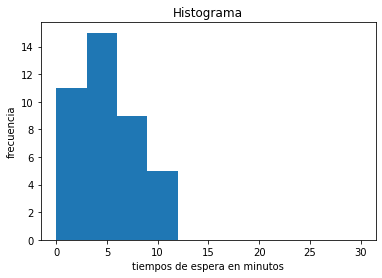

In [27]:
#Crear graficas de Tiempos de espera

print(wait_times) #dataset tiempos de espera
print('Tamaño: ',np.size(wait_times)) #tamaño muestra
print('Media: ',np.mean(wait_times)) #media
print('Sigma: ',np.std(wait_times)) #desv. std

plt.hist(wait_times, bins=10, range= (0, 30))
plt.ylabel('frecuencia')
plt.xlabel('tiempos de espera en minutos')
plt.title('Histograma')
plt.show

[1.1317505182270342, 4.831748005285337, 8.3467758069108, 9.327663877964266, 6.601136793752417, 13.813865441702902, 6.080317423038107, 13.123719275148975, 19.98347080105932, 13.56715438007678, 17.245887307972822, 13.485968027648198, 13.3209131124988, 15.771231900265832, 12.613577920961923, 11.062698112602448, 16.323124058563813, 12.801615618347263, 8.004408745508208, 12.554658407065205, 5.428702772257381, 2.7801074728278152, 9.971260251532065, 5.310826177919253, 8.423748693483077, 6.336847704807198, 8.503860471911622, 20.467208930500092, 9.69609414430407, 9.978475251667845, 13.556739157531823, 12.053802809826792, 10.680627390404979, 14.420975123714626, 4.716521487807498, 11.09641282805012, 7.441620901529689, 11.759504337276596]
Tamaño:  38
Media:  10.59513214320929
Sigma:  4.390275474053594


<function matplotlib.pyplot.show(*args, **kw)>

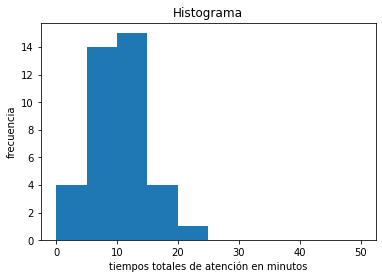

In [28]:
#Crear graficas de Tiempos totales de atención

print(total_times) #dataset tiempos totales de atencion
print('Tamaño: ',np.size(total_times)) #tamaño muestra
print('Media: ',np.mean(total_times)) #media
print('Sigma: ',np.std(total_times)) #desv. std

plt.hist(total_times, bins=10, range= (0, 50))
plt.ylabel('frecuencia')
plt.xlabel('tiempos totales de atención en minutos')
plt.title('Histograma')
plt.show

[1.1317505182270342, 3.699997487058303, 8.3467758069108, 4.495915872678929, 1.273472915788151, 5.467089634792101, 2.266451981335205, 9.043401852110868, 16.382334007306902, 2.4434351049278042, 7.262416506913503, 6.918813647571419, 3.8349450848506024, 4.52534459229301, 3.2926648084631225, 4.4491201916405245, 10.551892158297981, 4.738917505744816, 3.2027931271609447, 5.231534348501391, 2.8740443651921765, 1.3514047005704342, 5.966851506023858, 5.310826177919253, 8.112922515563824, 0.9130990113241211, 6.167012767104424, 20.467208930500092, 5.192233672392447, 5.511266321167753, 7.860645013227753, 8.075327558158946, 4.626824580578187, 7.864235966182804, 1.2955463640928713, 4.415785437645141, 6.725099413722191, 10.663091509226476]
Tamaño:  38
Media:  5.840855077978058
Sigma:  3.921210512430136


<function matplotlib.pyplot.show(*args, **kw)>

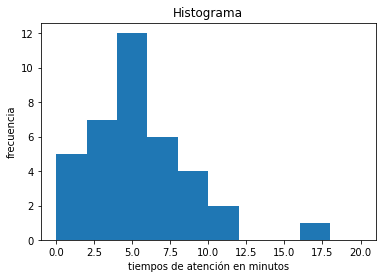

In [29]:
#Crear graficas de Tiempos de atención (solo el tiempo con ejecutivo)

print(support_times) #dataset tiempos de atencion
print('Tamaño: ',np.size(support_times)) #tamaño muestra
print('Media: ',np.mean(support_times)) #media
print('Sigma: ',np.std(support_times)) #desv. std

plt.hist(support_times, bins=10, range= (0, 20))
plt.ylabel('frecuencia')
plt.xlabel('tiempos de atención en minutos')
plt.title('Histograma')
plt.show

### aquí tus preguntas para evaluar ajustes al modelo:

* qué pasa sí ....
* ...